In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [3]:
import os
import PIL
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image


class FoodData(Dataset):
    def __init__(self, setname):
        self.selected_dataset_dir = os.getcwd()
        
        df = pd.read_csv('train.csv' ,header=0, index_col=0)
        self.num_classes = df['label'].max(0) + 1
        sep = int(len(df) * 0.9)

        if setname == 'train':
            self.all_filenames = list(df['path_img'][: sep])
            self.all_labels = df.set_index('path_img')[: sep]
        
        if setname == 'test':
            self.all_filenames = list(df['path_img'][sep :])
            self.all_labels = df.set_index('path_img')[sep :]

    

    def __len__(self):
        return len(self.all_filenames)
        

    def __getitem__(self, idx):
        selected_filename = self.all_filenames[idx]
        
        imagepil = PIL.Image.open(os.path.join(self.selected_dataset_dir,selected_filename)).convert('RGB').resize((252, 252), resample=Image.LANCZOS)

        transform = transforms.Compose(
            [transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        
        image = transform(imagepil)
        
        #load label
        label = torch.nn.functional.one_hot(torch.tensor(self.all_labels.loc[selected_filename]), self.num_classes)
        #label = torch.tensor(self.all_labels.loc[selected_filename])

        
        sample = {'data':image, #image, for input into NN
                  'label':label}
        return image, label

In [4]:
batch_size = 32

trainset = FoodData('train')
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=16)

testset = FoodData('test')
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=16)

classes = ('burger', 'chicken', 'doughnut', 'chips',
           'hot dog', 'pizza', 'sandwich', 'potato')

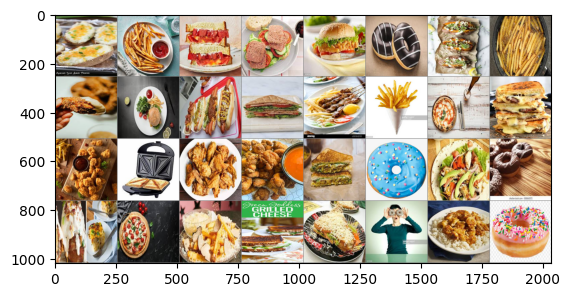

potato chips sandwich sandwich burger doughnut potato chips chicken burger hot dog sandwich chips chips pizza sandwich chicken sandwich chicken chicken sandwich doughnut chicken doughnut potato pizza chips sandwich sandwich doughnut chicken doughnut


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[torch.argmax(labels[j])]:5s}' for j in range(batch_size)))

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 248
        torch.nn.init.xavier_uniform_(self.conv1.weight)

        self.pool = nn.MaxPool2d(2, 2) # 124

        self.conv2 = nn.Conv2d(6, 16, 5) # 120
        torch.nn.init.xavier_uniform_(self.conv2.weight)

        self.fc1 = nn.Linear(16 * 60* 60, 300)
        torch.nn.init.xavier_uniform_(self.fc1.weight)

        self.fc2 = nn.Linear(300, 150)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

        self.fc3 = nn.Linear(150, 8)
        torch.nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=57600, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=150, bias=True)
  (fc3): Linear(in_features=150, out_features=8, bias=True)
)

In [9]:
# save
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
# load
net = Net()
net.load_state_dict(torch.load(PATH))
net.to(device)

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.05, weight_decay=0.001)

In [8]:
losses = []

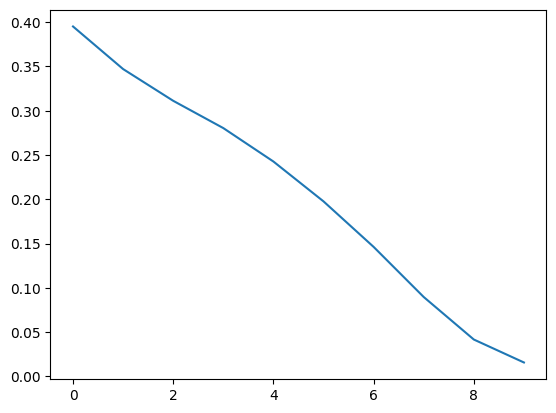

Finished Training


In [9]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 1):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), torch.flatten(data[1], 1).float().to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 0:    # print every 200 mini-batches
            #print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.3f}')
            losses.append(running_loss / 1000)
            running_loss = 0.0
            clear_output(wait = True)
            plt.plot(range(len(losses)), losses)
            plt.show()

print('Finished Training')

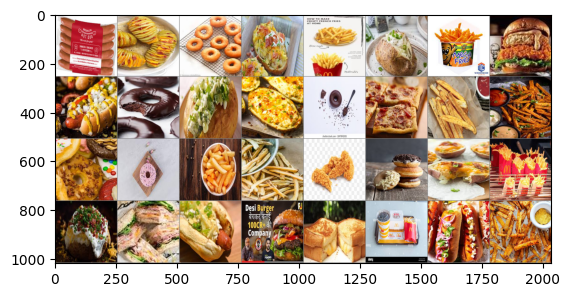

GroundTruth:  hot dog potato doughnut potato chips potato chips burger hot dog doughnut potato potato doughnut pizza chips chips doughnut doughnut chips chips chicken doughnut potato chips potato sandwich hot dog burger sandwich chips hot dog chips


In [95]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[torch.argmax(labels[j])]:5s}' for j in range(batch_size)))

In [96]:
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]}'
                              for j in range(batch_size)))

Predicted:  doughnut chips sandwich potato chips potato chips pizza potato doughnut chips potato doughnut pizza pizza chips chicken doughnut chips chips pizza sandwich potato sandwich burger doughnut pizza pizza pizza chips burger chips


In [10]:
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    correct, total = 0, 0
    for data in trainloader:
        inputs, labels = data[0].to(device), torch.flatten(data[1], 1).to(device)
        # calculate outputs by running images through the network
        outputs = net(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)

        correct += (predicted == torch.argmax(labels, 1)).sum().item()
    print(f'Accuracy of the network on the 90% train images: {100 * correct / total} %')
        
    correct, total = 0, 0
    for data in testloader:
        inputs, labels = data[0].to(device), torch.flatten(data[1], 1).to(device)
        # calculate outputs by running images through the network
        outputs = net(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)

        correct += (predicted == torch.argmax(labels, 1)).sum().item()
    print(f'Accuracy of the network on the 10% test images: {100 * correct / total} %')

/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Accuracy of the network on the 90% train images: 99.19563058589871 %
Accuracy of the network on the 10% test images: 45.75513851653262 %


In [11]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            label = torch.argmax(label, 1)
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: burger is 49.6 %
Accuracy for class: chicken is 42.1 %
Accuracy for class: doughnut is 65.1 %
Accuracy for class: chips is 36.5 %
Accuracy for class: hot dog is 55.6 %
Accuracy for class: pizza is 47.2 %
Accuracy for class: sandwich is 21.9 %
Accuracy for class: potato is 47.6 %
